Autor: Esteban Suárez Calvo

In [1]:
import io
from datetime import timedelta
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from qiskit.circuit.library import (
    PauliFeatureMap,
    ZFeatureMap,
    ZZFeatureMap,
    z_feature_map,
    zz_feature_map,
)
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.utils import algorithm_globals
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
)
from utils import RANDOM_SEED
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from ucimlrepo import fetch_ucirepo
from utils import display_confussion_matrix, show_metrics

# CCAM: Práctica final

Antes de nada, inicializamos la semilla de los números aleatorios para que los resultados sean reproducibles.

In [2]:
algorithm_globals.random_seed = RANDOM_SEED

## Preprocesado

### Dataset escogido: Spambase

El dataset escogido para esta práctica es [Spambase](https://archive.ics.uci.edu/dataset/94/spambase). Este dataset consta de 4601 instancias que representan correos electrónicos escritos en inglés. Cada correo electrónico está representado en base a 57 características y nuestro objetivo es detectar si un correo dado es un correo de **spam** (positivo) o si es **legítimo** (negativo). 

Destacar que queremos minimizar los falsos positivos, es decir, aquellos casos en los que un correo electrónico es legítimo pero lo clasificamos como spam, pues podría hacer que el usuario no reciba correos electrónicos importantes. Por lo tanto, a parte del *accuracy*, nos centraremos también en el ***precision*** (o valor predictivo positivo), que se define del siguiente modo:

$$
\text{precision} = \frac{VP}{VP + FP}
$$

es decir, maximizar el *precision* equivale a minimizar el número de falsos positivos.

Cada característica se corresponde con la frecuencia de una palabra en concreto, por ejemplo *make*, *all*, *our*...

### Importar el dataset

In [3]:
spambase = fetch_ucirepo(id=94)

X = spambase.data.features
y = spambase.data.targets

print(spambase.variables)

                          name     role        type demographic  \
0               word_freq_make  Feature  Continuous        None   
1            word_freq_address  Feature  Continuous        None   
2                word_freq_all  Feature  Continuous        None   
3                 word_freq_3d  Feature  Continuous        None   
4                word_freq_our  Feature  Continuous        None   
5               word_freq_over  Feature  Continuous        None   
6             word_freq_remove  Feature  Continuous        None   
7           word_freq_internet  Feature  Continuous        None   
8              word_freq_order  Feature  Continuous        None   
9               word_freq_mail  Feature  Continuous        None   
10           word_freq_receive  Feature  Continuous        None   
11              word_freq_will  Feature  Continuous        None   
12            word_freq_people  Feature  Continuous        None   
13            word_freq_report  Feature  Continuous        Non

### Normalización de los datos

In [4]:
X = MinMaxScaler().fit_transform(X)

### Reducción de la dimensionalidad

El dataset posee 57 caraterísticas. Debido a que vamos a trabajar con modelos cuánticos, cada una de estas características se codifica con un cúbit, y, puesto que vamos a trabajar con simuladores cuánticos, no podemos utilizar todas estas características tal cual debido a que no somos capaces de emular 57 cúbits en un ordenador clásico.

Por lo tanto, realizamos una reducción de la dimensionalidad empleando la técnica ***Principal Component Analysis (PCA)***, pasando de 57 características a 8.

In [5]:
X_8features = PCA(n_components=8).fit_transform(X)
number_of_features = X_8features.shape[1]
print(f"Nuevo número de características = {number_of_features}")

Nuevo número de características = 8


### Reducción del dataset

El dataset que estamos utilizando tiene 4600 datos en total. Debido al alto costo computacional de realizar el entrenamiento de los distintos clasificadores cuánticos, reduciremos esos datos a 1000, con el fin de acelerar así el proceso de entrenamiento.

In [6]:
X_subset, _, y_subset, _ = train_test_split(
    X_8features, y, train_size=1000, random_state=RANDOM_SEED, stratify=y
)

### Separar entrenamiento y test

A continuación, dividimos el dataset en tres conjuntos:

- Entrenamiento 70%
- Test 20%
- Validación 10%

In [7]:
X_rest, X_test, y_rest, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=RANDOM_SEED, stratify=y_subset
)

X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=0.1, random_state=RANDOM_SEED, stratify=y_rest
)

### Clasificar con un SVC clásico

Para comprobar que el problema se puede resolver tras haber reducido nuestro dataset y habiendo aplicado la reducción de características, vamos a entrenar y a clasificar un SVC.


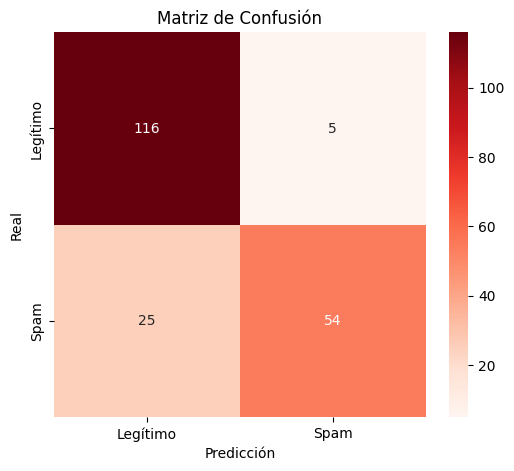

None

Accuracy: 0.8500
Precision: 0.9153


In [9]:
clf = SVC(kernel="linear")
clf.fit(X_train, y_train.values.ravel())

y_pred_test = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred_test)
display_confussion_matrix(cm)
show_metrics(cm)

Obtenemos un *accuracy* y un *precision* relativamente altos (teniendo en cuenta la reducción de la dimensionalidad y del tamaño del dataset que hemos realizado).

## Desarrolla una red neuronal cuántica (QNN)